In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from parameters import *
from lib.utils import *
from lib.attacks import *

import numpy as np
import tensorflow as tf

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
x_train, y_train, x_test, y_test = load_dataset_mnist()

y_train_cat = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test_cat = keras.utils.to_categorical(y_test, NUM_LABELS)

In [41]:
def random_sample(size):

    # Generate samples from g
    z = np.random.normal(0, 1, size)
    # Sampled labels
    y_sampled = np.random.randint(0, 10, size[0])
    return z, y_sampled

def generate_random(g, size):

    z, y_sampled = random_sample(size)
    x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)
    return x_g, y_sampled

def generate_ten(g, size):
    z = np.random.normal(0, 1, size)
    y_sampled = np.array([[i] * int(size[0] / 10) for i in range(10)]).flatten()
    x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)
    return x_g, y_sampled

def collage(images):
    img = (np.concatenate([np.concatenate([s for s in r], axis=1)
                           for r in np.split(images, 10)], axis=0) *
           127.5 + 127.5).astype(np.uint8)
    return np.squeeze(img)

def show(x):
    plt.imshow(x.reshape(28, 28) / 2 + 1, cmap='gray')
    plt.axis('off')
    plt.show()

In [6]:
def grad_acgan_cross_entropy(model):
    y_true = K.placeholder(shape=(OUTPUT_DIM, ))
    loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true, logits=model.output)
    grad = K.gradients(loss, model.input[0])
    return K.function([model.input[0], model.input[1], 
                       y_true, K.learning_phase()], grad)

def grad_acgan_hinge(model):
    
    labels = K.placeholder(shape=(OUTPUT_DIM, ), dtype=tf.int32)
    logits = model.output[0]
    i_label = tf.to_int32(tf.argmax(labels))
    y_label = logits[i_label]
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits))
    y_max = tf.where(tf.equal(i_label, i_max), 
                     y_2max[1], y_2max[0])
    loss = tf.maximum(0., 1. - y_label + y_max)
    grad = K.gradients(loss, model.input[0])
    return K.function([model.input[0], model.input[1], 
                       labels, K.learning_phase()], grad)

In [7]:
def PGD(model, x, y, grad_fn=None, norm="2", n_step=40, step_size=0.05,
        target=True, init_rnd=0.1):
    """
    PGD attack with random start
    """
    
    EPS = 1e-6
    x_adv = np.zeros_like(x)
    y_cat = keras.utils.to_categorical(y, NUM_LABELS)
    
    for i, x_cur in enumerate(x):
        epsilon = np.random.uniform(size=x_cur.shape) - 0.5
        if norm == "2":
            try:
                epsilon /= (np.linalg.norm(epsilon) + EPS)
            except ZeroDivisionError:
                raise
        elif norm == "inf":
            epsilon = np.sign(epsilon)
        else:
            raise ValueError("Invalid norm!")
        
        x_adv[i] = x_cur + init_rnd * epsilon
        
    if not grad_fn:
        grad_fn = gradient_fn(model)
    start_time = time.time()

    for i, x_in in enumerate(x_adv):
        print(i)
        x_cur = np.copy(x_in)
        # Start update in steps
        for _ in range(n_step):
            grad = grad_fn([x_in.reshape(1, -1), y[i].reshape(1, -1), 
                            y_cat[i], 0])[0][0]
            if target:
                grad *= -1
            if norm == "2":
                try:
                    grad /= (np.linalg.norm(grad) + EPS)
                except ZeroDivisionError:
                    raise
            elif norm == "inf":
                grad = np.sign(grad)
            else:
                raise ValueError("Invalid norm!")

            x_cur += grad * step_size
            loss = model.evaluate([x_cur[np.newaxis], y[i, np.newaxis]], 
                                  y[i, np.newaxis], verbose=0)[0]
#             out = model.predict([x_cur[np.newaxis], y[i, np.newaxis]], 
#                                 verbose=0)[0]
#             if np.argmax(out) != y[i]:
#                 loss = np.maximum(0, 1 - out[y[i]] + np.sort(out)[-1])
#             else:
#                 loss = np.maximum(0, 1 - out[y[i]] + np.sort(out)[-2])
            print(loss)

        x_adv[i] = np.copy(x_cur)

        # Progress printing
        if (i % 200 == 0) and (i > 0):
            elasped_time = time.time() - start_time
            print("Finished {} samples in {:.2f}s.".format(i, elasped_time))
            start_time = time.time()

    return x_adv

--- 

In [8]:
model = build_cnn_mnist()
#model.load_weights('./tmp/weights/mnist_cnn_hinge.h5')
model.load_weights('./tmp/weights/mnist_cnn_smxe.h5')
#model.load_weights('./tmp/mnist_cnn_margin_C1_L1/model.h5')
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [9]:
from lib.gan.model_acgan_mnist import *

latent_dim = 100
d = build_discriminator()
g = build_generator(latent_dim)
d.load_weights('./tmp/acgan_mnist/weight_d_epoch049.h5')
g.load_weights('./tmp/acgan_mnist/weight_g_epoch049.h5')

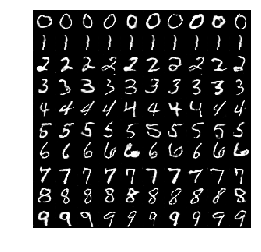

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   [0.53, 0.53, 0.57, 0.53, 0.56, 0.5, 0.54, 0.53, 0.52, 0.59]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   [0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   [0.49, 0.45, 0.46, 0.51, 0.5, 0.5, 0.46, 0.51, 0.56, 0.49]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   [0.51, 0.66, 0.58, 0.57, 0.57, 0.48, 0.53, 0.58, 0.55, 0.54]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]   [0.53, 0.54, 0.53, 0.5, 0.6, 0.59, 0.55, 0.56, 0.51, 0.48]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]   [0.45, 0.46, 0.53, 0.5, 0.56, 0.59, 0.54, 0.5, 0.66, 0.48]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]   [0.51, 0.52, 0.49, 0.53, 0.46, 0.48, 0.57, 0.47, 0.55, 0.51]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]   [0.54, 0.59, 0.55, 0.54, 0.54, 0.59, 0.57, 0.55, 0.61, 0.58]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]   [0.5, 0.46, 0.58, 0.58, 0.46, 0.52, 0.54, 0.54, 0.41, 0.51]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]   [0.48, 0.51, 0.62, 0.58, 0.55, 0.58, 0.46, 0.48, 0.54, 0.55]


In [51]:
# x_g, _ = generate_random(g, (100, latent_dim))
x_g, _ = generate_ten(g, (100, latent_dim))
plt.imshow(collage(x_g), cmap='gray')
plt.axis('off')
#plt.savefig('acgan_latent.png', bbox_inches='tight')
plt.show()

y_pred = []
fake = []

for i, x in enumerate(x_g):
    tmp = d.predict(x.reshape(1, 28, 28, 1))
    fake.append(round(float(tmp[0]), 2))
    y_pred.append(np.argmax(tmp[1]))
    if (i + 1) % 10 == 0:
        print("{}   {}".format(y_pred, fake))
        y_pred = []
        fake = []

In [46]:
latent = Input(shape=(latent_dim, ))
image_class = Input(shape=(1, ), dtype='int32')
img = g([latent, image_class])
y = model(img)
combine = Model(inputs=[latent, image_class], outputs=y)
combine.trainable=False
combine.compile(loss=keras.losses.sparse_categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

In [64]:
z, y = random_sample((50, latent_dim))
y_cat = keras.utils.to_categorical(y, NUM_LABELS)

In [65]:
grad_fn = grad_acgan_cross_entropy(combine)
# grad_fn = grad_acgan_hinge(combine)
x_adv = PGD(combine, z, y, grad_fn=grad_fn, norm="2", n_step=200, 
            step_size=0.01, target=False, init_rnd=0.)

0
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.0986124277114868
1.09861242

0.4423135221004486
0.414004921913147
0.3863191604614258
0.355623334646225
0.32496514916419983
0.29026415944099426
0.24601209163665771
0.20061644911766052
0.1559462696313858
0.1095026358962059
0.05983298271894455
0.006133542861789465
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
0.012214384973049164
0.028780370950698853
0.04150550812482834
0.05250537768006325
0.06406684219837189
0.07594773173332214
0.0871991217136383
0.09636063873767853
0.10622954368591309
0.11691948026418686
0.12794801592826843
0.13829031586647034
0.14643101394176483
0.15247073769569397
0.1574341058731079
0.16115842759609222
0.1631137877702713
0.1625595986843109
0.16221605241298676
0.16408640146255493
0.16527564823627472
0.16676843166351318
0.16877339780330658
0.17138706147670746
0.16989944875240326
0.16675713658332825
0.16251948475837708
0.15442301332950592
0.14803987741470337
0.141168013215065
0.13707537949085236
0.13360872864723206
0.13130354881286

1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593

0.9988213777542114
0.9960194826126099
0.9931764602661133
0.9904909729957581
0.9880945086479187
0.9855443239212036
9
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.07288303

0.2352510541677475
0.26022857427597046
0.2879526913166046
0.3195032477378845
0.35301047563552856
0.3834446668624878
0.41181227564811707
0.4347948431968689
0.450289249420166
0.46254611015319824
0.4735678434371948
0.4846969246864319
0.4973738193511963
0.5070233941078186
0.5123926997184753
0.5174081921577454
0.5220617651939392
0.5226047039031982
0.518925666809082
0.5059597492218018
0.4906516671180725
0.4738991856575012
0.4507632255554199
0.42710378766059875
0.4046734869480133
0.3802745044231415
0.35389435291290283
0.33640027046203613
0.3284202516078949
11
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.09

1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
13
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764


0.7781616449356079
0.7820978760719299
0.7867699265480042
0.7927714586257935
0.7990344762802124
0.805804431438446
0.8113880157470703
0.8160431385040283
0.8211020231246948
0.8251213431358337
0.8277484774589539
0.8305561542510986
0.8353061676025391
0.8414567708969116
0.8476717472076416
0.8535562753677368
0.8605751991271973
0.8673562407493591
0.8735392093658447
0.8790433406829834
0.8835625648498535
0.8879432082176208
0.8934746980667114
0.8992564082145691
0.9023921489715576
0.9045113325119019
0.9057511687278748
0.9063314199447632
0.9065544605255127
0.9070689678192139
0.9076391458511353
0.9080455899238586
0.9078469276428223
0.907660722732544
0.9069221615791321
0.9059094190597534
0.9050564169883728
0.9039599895477295
0.9021234512329102
0.8997905850410461
0.8976195454597473
0.8966531753540039
0.8973168730735779
0.8992297649383545
0.9014641642570496
0.9038649201393127
0.9075214266777039
0.9119198322296143
0.9164714217185974
0.9212209582328796
0.92523193359375
0.9300891757011414
0.93637639284133

0.3382117450237274
0.3257139027118683
0.3130896985530853
0.30164387822151184
0.2911316454410553
0.28228211402893066
0.27263855934143066
0.2649895250797272
0.25735461711883545
0.25149139761924744
0.24463656544685364
0.2365267276763916
0.22799482941627502
0.22024944424629211
0.21198996901512146
0.20409347116947174
0.19755662977695465
0.19111385941505432
0.18490053713321686
0.1774907112121582
0.16998443007469177
0.16126921772956848
0.1524302065372467
0.14383648335933685
0.1353255957365036
0.1274976134300232
0.12003350257873535
0.11246873438358307
0.10502909123897552
0.09702447801828384
0.09006371349096298
0.0839984193444252
0.07799722254276276
0.07326672226190567
0.06957945972681046
0.0676184743642807
0.06523168087005615
0.06332122534513474
0.06106949597597122
0.05791892483830452
0.05392313003540039
0.051559317857027054
0.04921838641166687
0.046856947243213654
0.044956956058740616
0.043631650507450104
0.043041132390499115
0.04288811236619949
0.04321148619055748
0.04299088940024376
0.04355

1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593

1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
24
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.07288303752284

9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.53673861

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
28
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125

0.9727042317390442
0.993297815322876
1.011784315109253
1.0311559438705444
1.0501198768615723
1.0688837766647339
1.0862585306167603
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.098612546920

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593

16.163959503173828
16.15467643737793
16.147418975830078
16.121826171875
16.084423065185547
16.050865173339844
16.023210525512695
16.00609016418457
15.995936393737793
15.986690521240234
15.97936725616455
15.97809886932373
15.974725723266602
15.966629981994629
15.95869255065918
15.954930305480957
15.95014762878418
15.943623542785645
15.929486274719238
15.915538787841797
15.898531913757324
15.887139320373535
15.88294792175293
4.114158630371094
3.2912421226501465
2.9769673347473145
2.8416996002197266
2.796814203262329
2.7814226150512695
2.7931365966796875
2.825911283493042
2.927617073059082
3.1714935302734375
3.80318546295166
15.817618370056152
15.798638343811035
15.784034729003906
15.766667366027832
15.741938591003418
15.71508502960205
15.687085151672363
15.651054382324219
15.606817245483398
15.55232048034668
15.474284172058105
15.377545356750488
15.261129379272461
15.124861717224121
14.961079597473145
14.756508827209473
14.482502937316895
14.119300842285156
13.54845142364502
13.061723709

0.8636898398399353
0.867265522480011
0.8702306747436523
0.8729623556137085
0.875121533870697
0.8763668537139893
0.8786217570304871
0.8817654848098755
0.8840463161468506
0.8855186104774475
0.8866187334060669
0.8875943422317505
0.8879321217536926
0.887837827205658
0.8874757885932922
0.8871767520904541
0.8874689340591431
0.8868913650512695
0.8853249549865723
0.8823654651641846
0.8789747357368469
0.8760952353477478
0.8734087944030762
0.8710126876831055
0.8681327104568481
0.8648560047149658
0.8595753312110901
0.8544439077377319
0.8478723168373108
0.8407421112060547
0.8334694504737854
0.8258841037750244
0.8178744316101074
0.8101792931556702
0.8021271228790283
0.7940824031829834
0.7865742444992065
0.7785372734069824
0.7690386772155762
0.757557213306427
0.7452381253242493
0.733040452003479
0.7218777537345886
0.7112175226211548
0.6995244026184082
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.693147659301757

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593

1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469207764
1.0986125469

1.246037483215332
1.249071478843689
1.2520047426223755
1.2543883323669434
1.2564815282821655
1.2589350938796997
1.2628583908081055
43
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
1.0728830375228426e-06
0.043933793902397156
0.097212053835392
0.15745100378990173
0.21628424525260925
0.27316591143608093
0.3294782340526581
0.3838571310043335
0.4331025779247284
0.4841996431350708
0.5282021164894104
0.5617849826812744
0.5865753889083862
0.6084436178207397
0.623324990272522
0.6422353982925415
0.653788685798645
0.6603230834007263
0.661666750907898
0.6604893207550049
0.659051775932312
0.6650336980819702
0.669281542301178
0.6732853651046753
0.6804571747779846
0.6901392936706543
0.6969078183174133
0.7035372853279114
0.7041201591491699
0.6990054845809937
0.6946541666984558
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.69314

16.08574676513672
16.09158706665039
16.09656524658203
16.100406646728516
16.103546142578125
16.107532501220703
16.112071990966797
16.116289138793945
16.120447158813477
16.12325096130371
16.124624252319336
16.126211166381836
16.12793731689453
16.129777908325195
16.131362915039062
16.131610870361328
16.12779426574707
16.12310791015625
16.118337631225586
16.112960815429688
16.10742950439453
16.10166358947754
16.095195770263672
16.087772369384766
16.07958984375
16.071380615234375
16.064395904541016
16.05714988708496
16.049795150756836
16.041778564453125
16.033710479736328
16.02584457397461
16.018709182739258
16.011886596679688
16.00558853149414
16.000076293945312
15.994638442993164
15.989320755004883
15.9840669631958
15.97823715209961
15.971118927001953
15.963220596313477
15.955464363098145
15.947693824768066
15.939922332763672
15.932907104492188
15.925670623779297
15.918753623962402
15.912318229675293
15.905619621276855
15.898460388183594
15.891311645507812
15.886553764343262
15.882039070

9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
9.536738616588991e-07
0.005795935168862343
0.023789912462234497
0.04090457782149315
0.06323584914207458
0.08484618365764618
0.10727629065513611
0.12748681008815765
0.14303646981716156
0.15477916598320007
0.16712969541549683
0.17740097641944885
0.18625332415103912
0.194062277674675
0.20043794810771942
0.2044457644224167
0.20495158433914185

0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593017578
0.6931476593

In [66]:
x = g.predict([x_adv, y])

In [72]:
y_pred = np.argmax(combine.predict([x_adv, y]), axis=1)

In [75]:
x_adv = x[y != y_pred]
y_adv = y[y != y_pred]

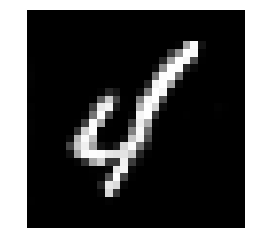

4
1


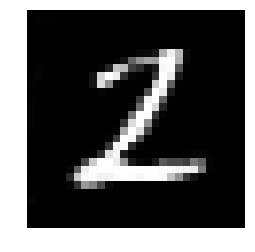

2
1


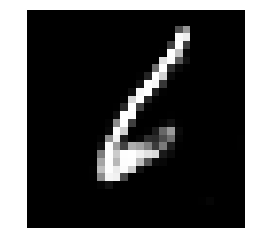

6
1


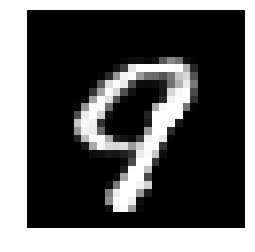

9
7


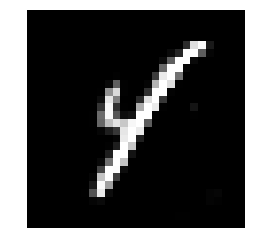

4
1


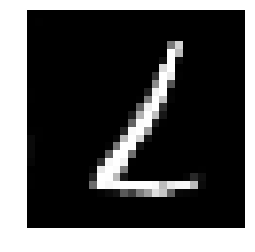

2
1


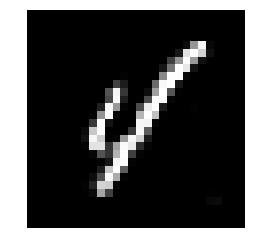

4
1


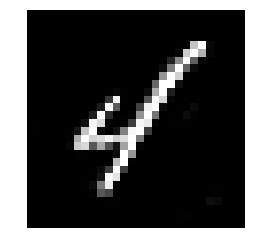

4
1


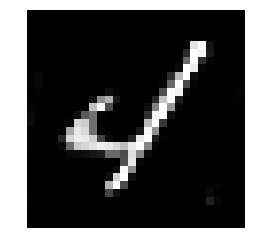

4
1


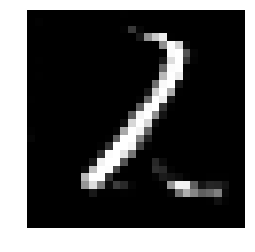

2
1


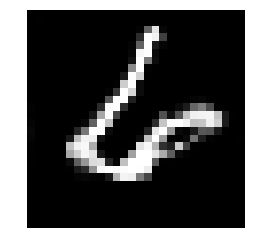

6
4


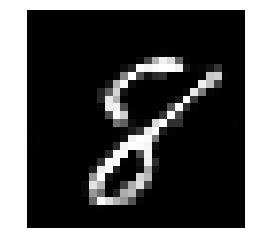

8
5


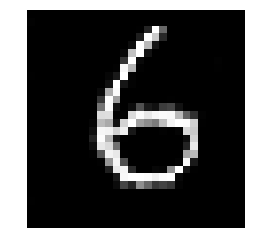

6
5


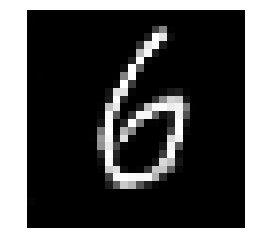

6
5


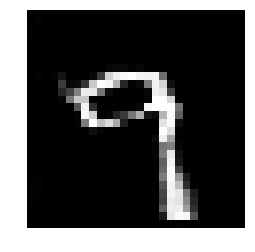

9
7


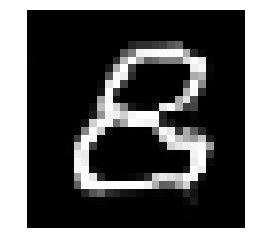

8
5


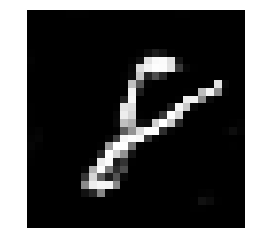

8
5


In [78]:
for i, (x_cur, y_cur) in enumerate(zip(x_adv, y_adv)):
    plt.imshow(x_cur.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.savefig('./tmp/gan/pgd/{}.png'.format(i), bbox_inches='tight')
    plt.show()
    print(y_cur)
    print(np.argmax(model.predict(x_cur.reshape(1, 28, 28, 1))))

In [71]:
np.max(x_adv[1])

2.158767970187227

In [ ]:
figure = plt.subplot(1, 10, figsize=(4))
for x_cur in x:
    plt.imshow(x_cur.reshape(28, 28))
    plt.show()
    print(model.predict(x_cur.reshape(1, 28, 28, 1)))

---
Simply iterate until a misclassification is found

In [83]:
adv_found = False
i = 0
while not adv_found:
    i += 1
    z, y = random_sample((100, latent_dim))
    y_pred = np.argmax(combine.predict([z, y]), axis=1)
    if np.sum(y_pred == y) != 100:
        z_adv, y_adv = z[y_pred != y], y[y_pred != y]
        break
print(i * 100)

100


In [84]:
np.sum(y_pred == y)

87

In [55]:
x = g.predict([z_adv, y_adv])

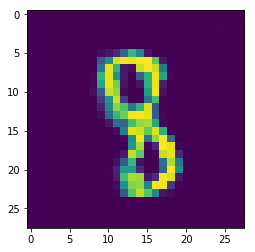

In [62]:
plt.imshow(x[5].reshape(28, 28))

In [57]:
np.argmax(model.predict(x), axis=1)

array([1, 7, 1, 5, 5, 3, 5, 5, 1, 5, 7, 5, 3, 1, 7, 1, 1, 4, 5, 7, 4, 4,
       1, 5, 1, 7, 4, 4, 1, 7, 1, 1, 4, 4, 5, 5, 1, 7, 1, 1, 3, 5, 1, 3,
       4, 7, 1, 1, 5, 1, 4, 1, 1, 5, 7, 3, 7, 4, 5, 5, 5, 1, 1, 5, 7, 1,
       4, 5, 5, 3, 1, 5, 1, 1, 5, 3, 1, 1, 1, 1, 5, 1, 1, 5, 1, 5, 1, 5,
       1, 5, 1, 1, 4, 5, 4])

In [85]:
x_adv = g.predict([z_adv, y_adv])

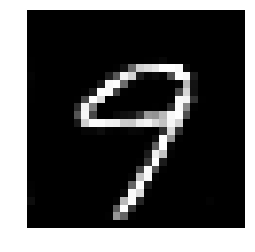

9
4


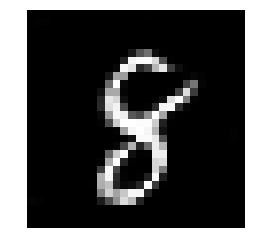

8
5


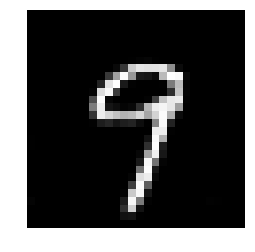

9
7


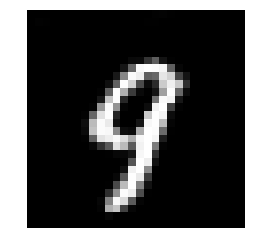

9
7


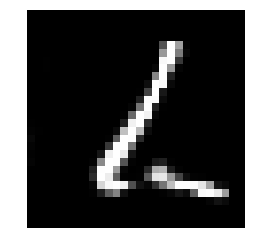

2
1


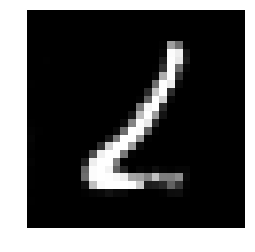

2
1


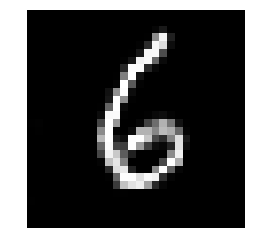

6
5


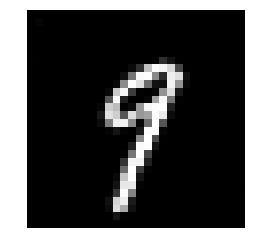

9
4


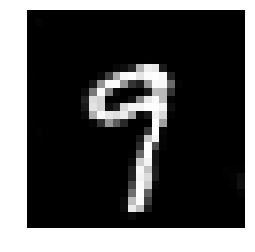

9
4


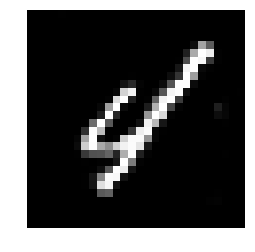

4
1


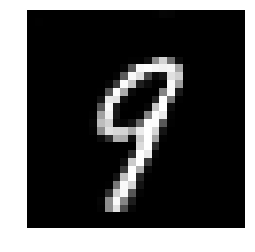

9
7


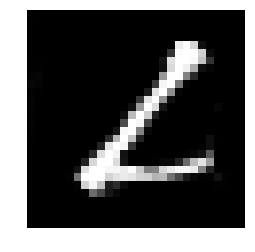

2
1


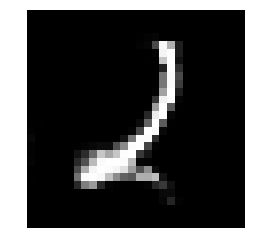

2
1


In [86]:
for i, (x_cur, y_cur) in enumerate(zip(x_adv, y_adv)):
    plt.imshow(x_cur.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.savefig('./tmp/gan/rnd/{}.png'.format(i), bbox_inches='tight')
    plt.show()
    print(y_cur)
    print(np.argmax(model.predict(x_cur.reshape(1, 28, 28, 1))))

In [ ]:
# try different loss function

---

In [79]:
from lib.OptCarlini_GAN import *

z, y = random_sample((50, latent_dim))
y_cat = keras.utils.to_categorical(y, NUM_LABELS)

opt = OptCarlini_GAN(combine, target=False, c=1, lr=0.01, init_scl=1e-6,
                     loss_op=0, k=0, use_mask=False, decay=True)

x_adv = np.zeros_like(z)
norm = np.zeros(len(z))

for i, (zi, yi) in enumerate(zip(z, y_cat)):
    x_adv[i], norm[i] = opt.optimize(zi, yi, 
                                     './tmp/gan/acgan_cnn_smxe_mnist.h5', 
                                     n_step=1000, prog=True)

Step: 0, norm=0.100, loss=6.327, obj=6.427
Step: 50, norm=0.818, loss=2.802, obj=3.620
Step: 100, norm=0.897, loss=1.986, obj=2.882
Step: 150, norm=1.089, loss=1.431, obj=2.520
Step: 200, norm=1.312, loss=1.039, obj=2.351
Step: 250, norm=1.446, loss=0.804, obj=2.251
Step: 300, norm=1.534, loss=0.251, obj=1.785
Step: 350, norm=1.574, loss=0.014, obj=1.588
Step: 400, norm=1.536, loss=0.000, obj=1.536
Step: 450, norm=1.519, loss=0.003, obj=1.522
Step: 500, norm=1.497, loss=0.001, obj=1.498
Step: 550, norm=1.496, loss=0.000, obj=1.496
Step: 600, norm=1.492, loss=0.002, obj=1.494
Step: 650, norm=1.501, loss=0.000, obj=1.501
Step: 700, norm=1.495, loss=0.000, obj=1.495
Step: 750, norm=1.493, loss=0.003, obj=1.496
Step: 800, norm=1.492, loss=0.000, obj=1.492
Step: 850, norm=1.490, loss=0.003, obj=1.492
Step: 900, norm=1.492, loss=0.000, obj=1.492
Step: 950, norm=1.489, loss=0.001, obj=1.490
Step: 0, norm=0.100, loss=1.417, obj=1.517
Step: 50, norm=0.306, loss=0.000, obj=0.306
Step: 100, norm=

Step: 150, norm=1.243, loss=2.054, obj=3.297
Step: 200, norm=1.457, loss=1.690, obj=3.147
Step: 250, norm=1.612, loss=1.477, obj=3.089
Step: 300, norm=1.695, loss=1.358, obj=3.053
Step: 350, norm=1.766, loss=1.201, obj=2.967
Step: 400, norm=1.937, loss=0.835, obj=2.772
Step: 450, norm=1.938, loss=0.811, obj=2.749
Step: 500, norm=1.924, loss=0.820, obj=2.744
Step: 550, norm=1.922, loss=0.822, obj=2.744
Step: 600, norm=1.919, loss=0.825, obj=2.744
Step: 650, norm=1.918, loss=0.826, obj=2.744
Step: 700, norm=1.918, loss=0.825, obj=2.744
Step: 750, norm=1.917, loss=0.826, obj=2.744
Step: 800, norm=1.918, loss=0.826, obj=2.744
Step: 850, norm=1.917, loss=0.827, obj=2.744
Step: 900, norm=1.919, loss=0.824, obj=2.744
Step: 950, norm=1.918, loss=0.826, obj=2.744
Step: 0, norm=0.100, loss=2.484, obj=2.584
Step: 50, norm=0.586, loss=0.000, obj=0.586
Step: 100, norm=0.519, loss=0.000, obj=0.519
Step: 150, norm=0.512, loss=0.000, obj=0.512
Step: 200, norm=0.522, loss=0.000, obj=0.522
Step: 250, no

Step: 300, norm=0.002, loss=0.000, obj=0.002
Step: 350, norm=0.003, loss=0.000, obj=0.003
Step: 400, norm=0.002, loss=0.000, obj=0.002
Step: 450, norm=0.002, loss=0.000, obj=0.002
Step: 500, norm=0.003, loss=0.000, obj=0.003
Step: 550, norm=0.003, loss=0.000, obj=0.003
Step: 600, norm=0.003, loss=0.000, obj=0.003
Step: 650, norm=0.002, loss=0.000, obj=0.002
Step: 700, norm=0.002, loss=0.000, obj=0.002
Step: 750, norm=0.003, loss=0.000, obj=0.003
Step: 800, norm=0.002, loss=0.000, obj=0.002
Step: 850, norm=0.003, loss=0.000, obj=0.003
Step: 900, norm=0.002, loss=0.000, obj=0.002
Step: 950, norm=0.002, loss=0.000, obj=0.002
Step: 0, norm=0.100, loss=0.000, obj=0.100
Step: 50, norm=0.004, loss=0.000, obj=0.004
Step: 100, norm=0.004, loss=0.000, obj=0.004
Step: 150, norm=0.004, loss=0.000, obj=0.004
Step: 200, norm=0.004, loss=0.000, obj=0.004
Step: 250, norm=0.003, loss=0.000, obj=0.003
Step: 300, norm=0.002, loss=0.000, obj=0.002
Step: 350, norm=0.003, loss=0.000, obj=0.003
Step: 400, no

Step: 450, norm=0.642, loss=0.196, obj=0.838
Step: 500, norm=0.640, loss=0.198, obj=0.838
Step: 550, norm=0.641, loss=0.200, obj=0.841
Step: 600, norm=0.636, loss=0.205, obj=0.840
Step: 650, norm=0.643, loss=0.195, obj=0.838
Step: 700, norm=0.641, loss=0.198, obj=0.838
Step: 750, norm=0.642, loss=0.196, obj=0.838
Step: 800, norm=0.642, loss=0.196, obj=0.838
Step: 850, norm=0.639, loss=0.200, obj=0.839
Step: 900, norm=0.640, loss=0.199, obj=0.839
Step: 950, norm=0.642, loss=0.197, obj=0.839
Step: 0, norm=0.100, loss=0.189, obj=0.289
Step: 50, norm=0.051, loss=0.000, obj=0.051
Step: 100, norm=0.045, loss=0.000, obj=0.045
Step: 150, norm=0.046, loss=0.000, obj=0.046
Step: 200, norm=0.045, loss=0.000, obj=0.045
Step: 250, norm=0.043, loss=0.000, obj=0.043
Step: 300, norm=0.044, loss=0.000, obj=0.044
Step: 350, norm=0.043, loss=0.000, obj=0.043
Step: 400, norm=0.042, loss=0.000, obj=0.042
Step: 450, norm=0.041, loss=0.000, obj=0.041
Step: 500, norm=0.041, loss=0.000, obj=0.041
Step: 550, no

Step: 600, norm=0.271, loss=0.000, obj=0.271
Step: 650, norm=0.268, loss=0.000, obj=0.268
Step: 700, norm=0.269, loss=0.000, obj=0.269
Step: 750, norm=0.271, loss=0.000, obj=0.271
Step: 800, norm=0.272, loss=0.000, obj=0.272
Step: 850, norm=0.265, loss=0.014, obj=0.279
Step: 900, norm=0.269, loss=0.000, obj=0.269
Step: 950, norm=0.271, loss=0.000, obj=0.271
Step: 0, norm=0.100, loss=9.362, obj=9.462
Step: 50, norm=0.732, loss=5.681, obj=6.413
Step: 100, norm=0.706, loss=5.577, obj=6.283
Step: 150, norm=0.690, loss=5.590, obj=6.280
Step: 200, norm=0.691, loss=5.589, obj=6.280
Step: 250, norm=0.692, loss=5.588, obj=6.280
Step: 300, norm=0.691, loss=5.590, obj=6.281
Step: 350, norm=0.691, loss=5.589, obj=6.280
Step: 400, norm=0.691, loss=5.589, obj=6.280
Step: 450, norm=0.691, loss=5.589, obj=6.280
Step: 500, norm=0.692, loss=5.588, obj=6.280
Step: 550, norm=0.691, loss=5.588, obj=6.280
Step: 600, norm=0.692, loss=5.588, obj=6.280
Step: 650, norm=0.692, loss=5.589, obj=6.281
Step: 700, no

Step: 750, norm=0.003, loss=0.000, obj=0.003
Step: 800, norm=0.002, loss=0.000, obj=0.002
Step: 850, norm=0.003, loss=0.000, obj=0.003
Step: 900, norm=0.002, loss=0.000, obj=0.002
Step: 950, norm=0.002, loss=0.000, obj=0.002
Step: 0, norm=0.100, loss=8.621, obj=8.721
Step: 50, norm=0.376, loss=7.191, obj=7.566
Step: 100, norm=0.391, loss=7.162, obj=7.553
Step: 150, norm=0.392, loss=7.161, obj=7.553
Step: 200, norm=0.392, loss=7.161, obj=7.553
Step: 250, norm=0.393, loss=7.160, obj=7.553
Step: 300, norm=0.392, loss=7.162, obj=7.553
Step: 350, norm=0.392, loss=7.161, obj=7.553
Step: 400, norm=0.392, loss=7.161, obj=7.553
Step: 450, norm=0.391, loss=7.162, obj=7.553
Step: 500, norm=0.391, loss=7.162, obj=7.553
Step: 550, norm=0.391, loss=7.162, obj=7.553
Step: 600, norm=0.391, loss=7.162, obj=7.553
Step: 650, norm=0.392, loss=7.161, obj=7.553
Step: 700, norm=0.391, loss=7.162, obj=7.553
Step: 750, norm=0.392, loss=7.160, obj=7.553
Step: 800, norm=0.391, loss=7.162, obj=7.553
Step: 850, no

In [80]:
x = g.predict([x_adv, y])
y_pred = np.argmax(combine.predict([x_adv, y]), axis=1)
x_adv = x[y != y_pred]
y_adv = y[y != y_pred]

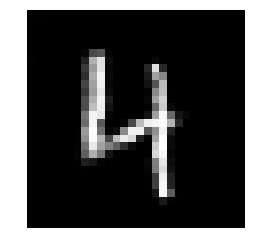

4
7


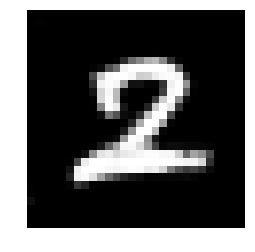

2
7


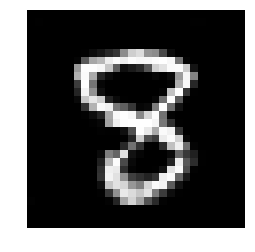

8
3


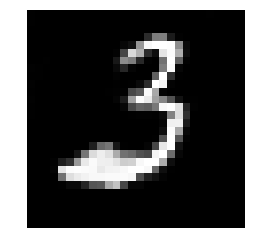

3
5


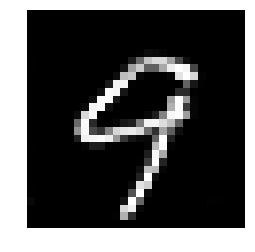

9
4


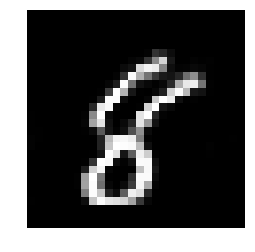

8
5


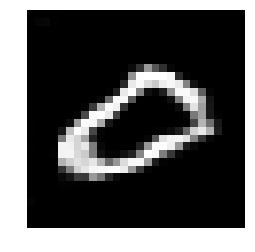

0
7


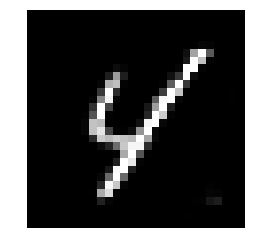

4
7


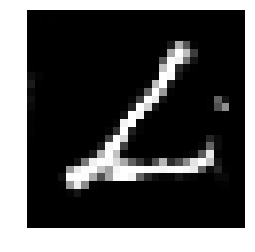

2
1


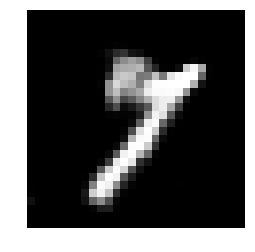

7
1


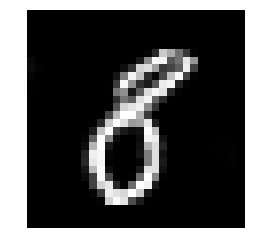

8
5


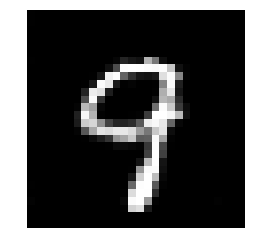

9
4


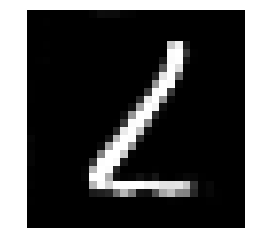

2
1


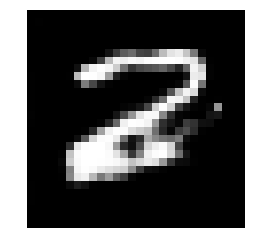

2
7


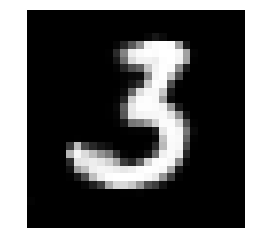

3
5


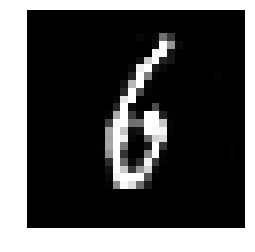

6
5


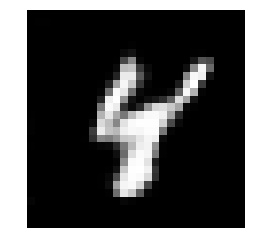

4
7


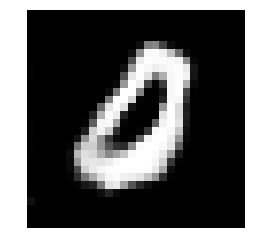

0
7


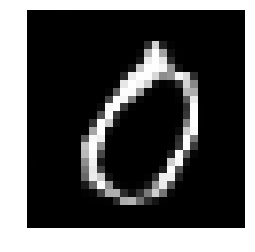

0
1


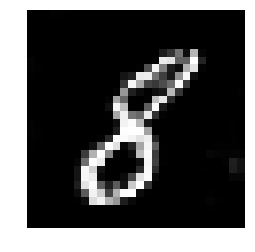

8
5


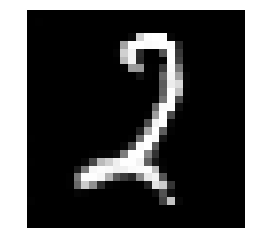

2
1


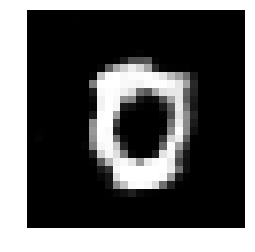

0
6


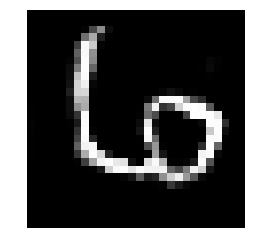

6
5


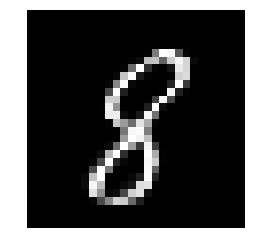

8
5


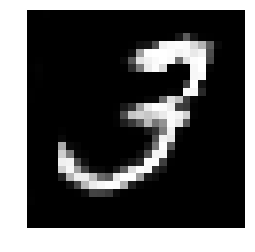

3
5


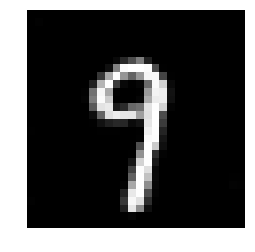

9
4


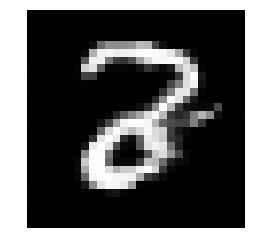

2
8


In [82]:
for i, (x_cur, y_cur) in enumerate(zip(x_adv, y_adv)):
    plt.imshow(x_cur.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.savefig('./tmp/gan/cw/{}.png'.format(i), bbox_inches='tight')
    plt.show()
    print(y_cur)
    print(np.argmax(model.predict(x_cur.reshape(1, 28, 28, 1))))

In [13]:
combine.save_weights('temp.h5')

In [14]:
latent = Input(shape=(latent_dim, ))
image_class = Input(shape=(1, ), dtype='int32')
img = g([latent, image_class])
y = model(img)
combine = Model(inputs=[latent, image_class], outputs=y)

In [15]:
combine.load_weights('temp.h5')

In [16]:
combine.input[0].shape[1].value

100

In [17]:
combine.get_input_at(0)

[<tf.Tensor 'input_6:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'input_7:0' shape=(?, 1) dtype=int32>]

---

In [20]:
x_train, y_train, x_test, y_test = load_dataset_fmnist()

In [27]:
len(x_test)

10000

In [ ]:
# PGD: 915 178 0.19453551912568307
# CW: 922 402 0.4360086767895879